In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

import io # Input/Output Module
import os # OS interfaces
import cv2 # OpenCV package
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pickle  # import pickle, to read and save variables

from urllib import request # module for opening HTTP requests
from matplotlib import pyplot as plt # Plotting library

<div style="width:100%; height:140px">
    <img src="https://www.kuleuven.be/internationaal/thinktank/fotos-en-logos/ku-leuven-logo.png/image_preview" width = 300px, heigh = auto align=left>
</div>


KUL H02A5a Computer Vision: Group Assignment 1
---------------------------------------------------------------
Student numbers: <span style="color:red">r1, r2, r3, r4, r5</span>.

The goal of this assignment is to explore more advanced techniques for constructing features that better describe objects of interest and to perform face recognition using these features. This assignment will be delivered in groups of 5 (either composed by you or randomly assigned by your TA's).

In this assignment you are a group of computer vision experts that have been invited to ECCV 2021 to do a tutorial about  "Feature representations, then and now". To prepare the tutorial you are asked to participate in a kaggle competition and to release a notebook that can be easily studied by the tutorial participants. Your target audience is: (master) students who want to get a first hands-on introduction to the techniques that you apply.

---------------------------------------------------------------
This notebook is structured as follows:
0. Data loading & Preprocessing
1. Feature Representations
2. Evaluation Metrics 
3. Classifiers
4. Experiments
5. Publishing best results
6. Discussion

Make sure that your notebook is **self-contained** and **fully documented**. Walk us through all steps of your code. Treat your notebook as a tutorial for students who need to get a first hands-on introduction to the techniques that you apply. Provide strong arguments for the design choices that you made and what insights you got from your experiments. Make use of the *Group assignment* forum/discussion board on Toledo if you have any questions.

Fill in your student numbers above and get to it! Good luck! 


<div class="alert alert-block alert-info">
<b>NOTE:</b> This notebook is just a example/template, feel free to adjust in any way you please! Just keep things organised and document accordingly!
</div>

<div class="alert alert-block alert-info">
<b>NOTE:</b> Clearly indicate the improvements that you make!!! You can for instance use titles like: <i>3.1. Improvement: Non-linear SVM with RBF Kernel.<i>
</div>
    
---------------------------------------------------------------
# 0. Data loading & Preprocessing

## 0.1. Loading data
The training set is many times smaller than the test set and this might strike you as odd, however, this is close to a real world scenario where your system might be put through daily use! In this session we will try to do the best we can with the data that we've got! 

In [2]:
# Input data files are available in the read-only "../input/" directory

# If using kaggle:
base_file_path = "/kaggle/input/kul-h02a5a-computer-vision-ga1-2022/"
# For Thibeau: If using offline notebook:
base_file_path = "D:\Coding\MAI\CV\Group_Assignments\data"

train = pd.read_csv(
    os.path.join(base_file_path, 'train_set.csv'), index_col = 0)
train.index = train.index.rename('id')

test = pd.read_csv(
    os.path.join(base_file_path, 'test_set.csv'), index_col = 0)
test.index = test.index.rename('id')

# read the images as numpy arrays and store in "img" column
train['img'] = [cv2.cvtColor(np.load(os.path.join(base_file_path, 'train/train_{}.npy').format(index), allow_pickle=False), cv2.COLOR_BGR2RGB) 
                for index, row in train.iterrows()]

test['img'] = [cv2.cvtColor(np.load(os.path.join(base_file_path, 'test/test_{}.npy').format(index), allow_pickle=False), cv2.COLOR_BGR2RGB) 
                for index, row in test.iterrows()]
  

train_size, test_size = len(train), len(test)

"The training set contains {} examples, the test set contains {} examples.".format(train_size, test_size)

'The training set contains 80 examples, the test set contains 1816 examples.'

*Note: this dataset is a subset of the* [*VGG face dataset*](https://www.robots.ox.ac.uk/~vgg/data/vgg_face/).

## 0.2. A first look
Let's have a look at the data columns and class distribution.

In [3]:
# The training set contains an identifier, name, image information and class label
train.head(1)

,name,class,img
id,,,
0,Mila_Kunis,2,"[[[50, 31, 25], [49, 30, 24], [49, 30, 24], [4..."


In [4]:
# The test set only contains an identifier and corresponding image information.

test.head(1)

,img
id,
0,"[[[209, 210, 205], [208, 209, 204], [208, 209,..."


In [5]:
# The class distribution in the training set:
train.groupby('name').agg({'img':'count', 'class': 'max'})

,img,class
name,,
Jesse_Eisenberg,30,1
Michael_Cera,10,0
Mila_Kunis,30,2
Sarah_Hyland,10,0


Note that **Jesse is assigned the classification label 1**, and **Mila is assigned the classification label 2**. The dataset also contains 20 images of **look alikes (assigned classification label 0)** and the raw images. 

## 0.3. Preprocess data
### 0.3.1 Example: HAAR face detector
In this example we use the [HAAR feature based cascade classifiers](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_objdetect/py_face_detection/py_face_detection.html) to detect faces, then the faces are resized so that they all have the same shape. If there are multiple faces in an image, we only take the first one. 

<div class="alert alert-block alert-info"> <b>NOTE:</b> You can write temporary files to <code>/kaggle/temp/</code> or <code>../../tmp</code>, but they won't be saved outside of the current session
</div>


In [6]:
class HAARPreprocessor():
    """Preprocessing pipeline built around HAAR feature based cascade classifiers. """
    
    def __init__(self, path, face_size):
        self.face_size = face_size
        file_path = os.path.join(path, "haarcascade_frontalface_default.xml")
        if not os.path.exists(file_path): 
            if not os.path.exists(path):
                os.mkdir(path)
            self.download_model(file_path)
        
        self.classifier = cv2.CascadeClassifier(file_path)
  
    def download_model(self, path):
        url = "https://raw.githubusercontent.com/opencv/opencv/master/data/"\
            "haarcascades/haarcascade_frontalface_default.xml"
        
        with request.urlopen(url) as r, open(path, 'wb') as f:
            f.write(r.read())
            
    def detect_faces(self, img):
        """Detect all faces in an image."""
        
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        return self.classifier.detectMultiScale(
            img_gray,
            scaleFactor=1.2,
            minNeighbors=5,
            minSize=(30, 30),
            flags=cv2.CASCADE_SCALE_IMAGE
        )
        
    def extract_faces(self, img):
        """Returns all faces (cropped) in an image."""
        
        faces = self.detect_faces(img)

        return [img[y:y+h, x:x+w] for (x, y, w, h) in faces]
    
    def preprocess(self, data_row):
        faces = self.extract_faces(data_row['img'])
        
        # if no faces were found, return None
        if len(faces) == 0:
            nan_img = np.empty(self.face_size + (3,))
            nan_img[:] = np.nan
            return nan_img
        
        # only return the first face
        return cv2.resize(faces[0], self.face_size, interpolation = cv2.INTER_AREA)
            
    def __call__(self, data):
        return np.stack([self.preprocess(row) for _, row in data.iterrows()]).astype(int)

**Visualise**

Let's plot a few examples.

In [7]:
# parameter to play with 
FACE_SIZE = (50, 50)

def plot_image_sequence(data, n, imgs_per_row=7):
    n_rows = 1 + int(n/(imgs_per_row+1))
    n_cols = min(imgs_per_row, n)

    f,ax = plt.subplots(n_rows,n_cols, figsize=(10*n_cols,10*n_rows))
    for i in range(n):
        if n == 1:
            ax.imshow(data[i])
        elif n_rows > 1:
            ax[int(i/imgs_per_row),int(i%imgs_per_row)].imshow(data[i])
        else:
            ax[int(i%n)].imshow(data[i])
    plt.show()

    
#preprocessed data 
preprocessor = HAARPreprocessor(path = '../../tmp', face_size=FACE_SIZE)

train_X, train_y = preprocessor(train), train['class'].values
test_X = preprocessor(test)



C:\Users\thibe\AppData\Local\Temp\ipykernel_12776\4005177570.py:53: RuntimeWarning: invalid value encountered in cast
  return np.stack([self.preprocess(row) for _, row in data.iterrows()]).astype(int)


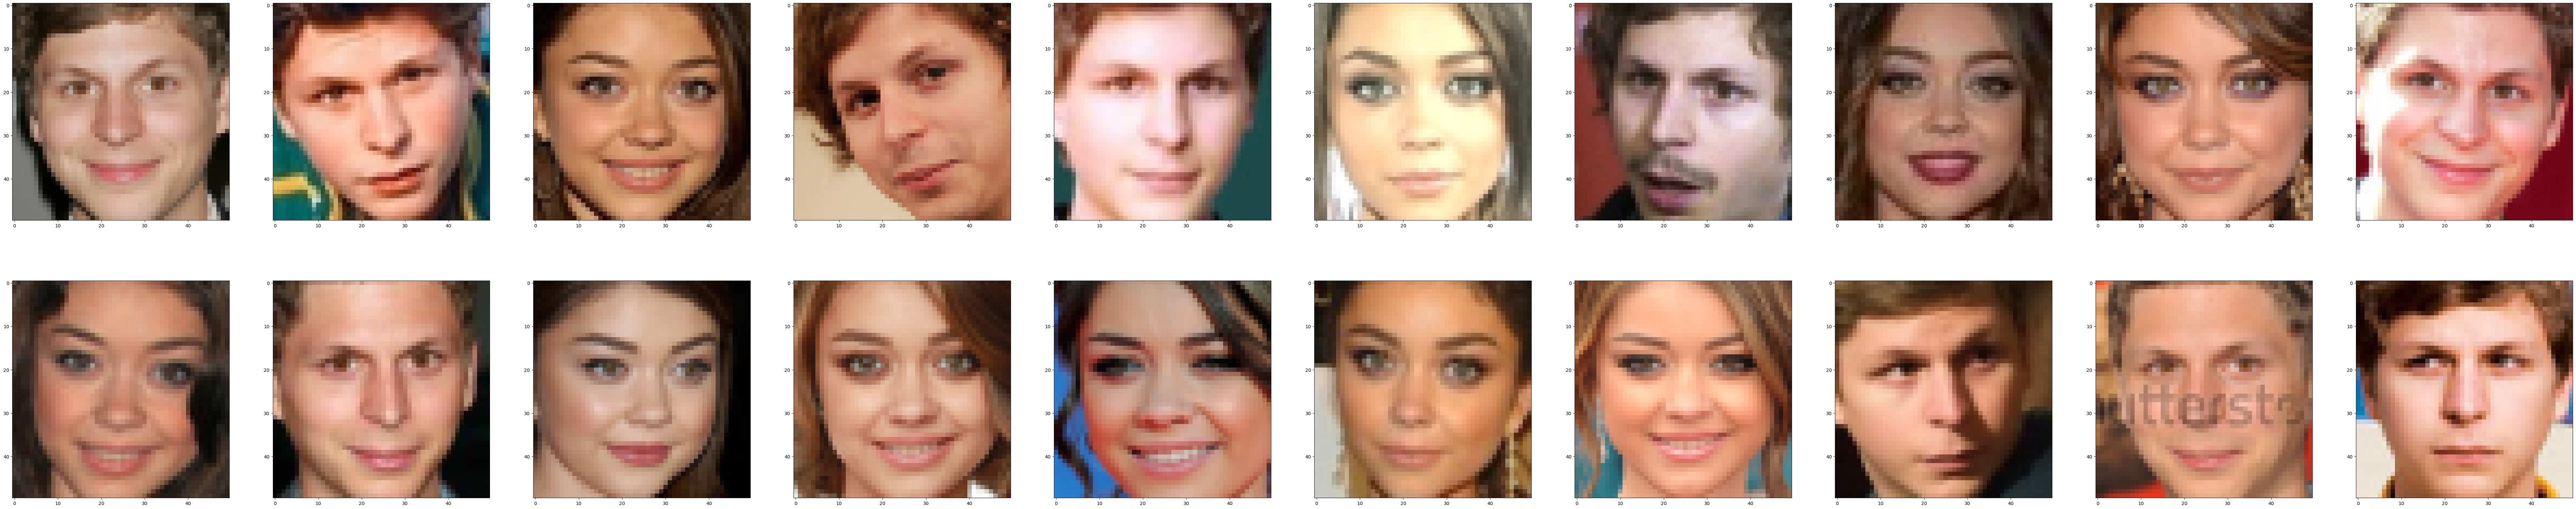

In [8]:
# plot faces of Michael and Sarah

plot_image_sequence(train_X[train_y == 0], n=20, imgs_per_row=10)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


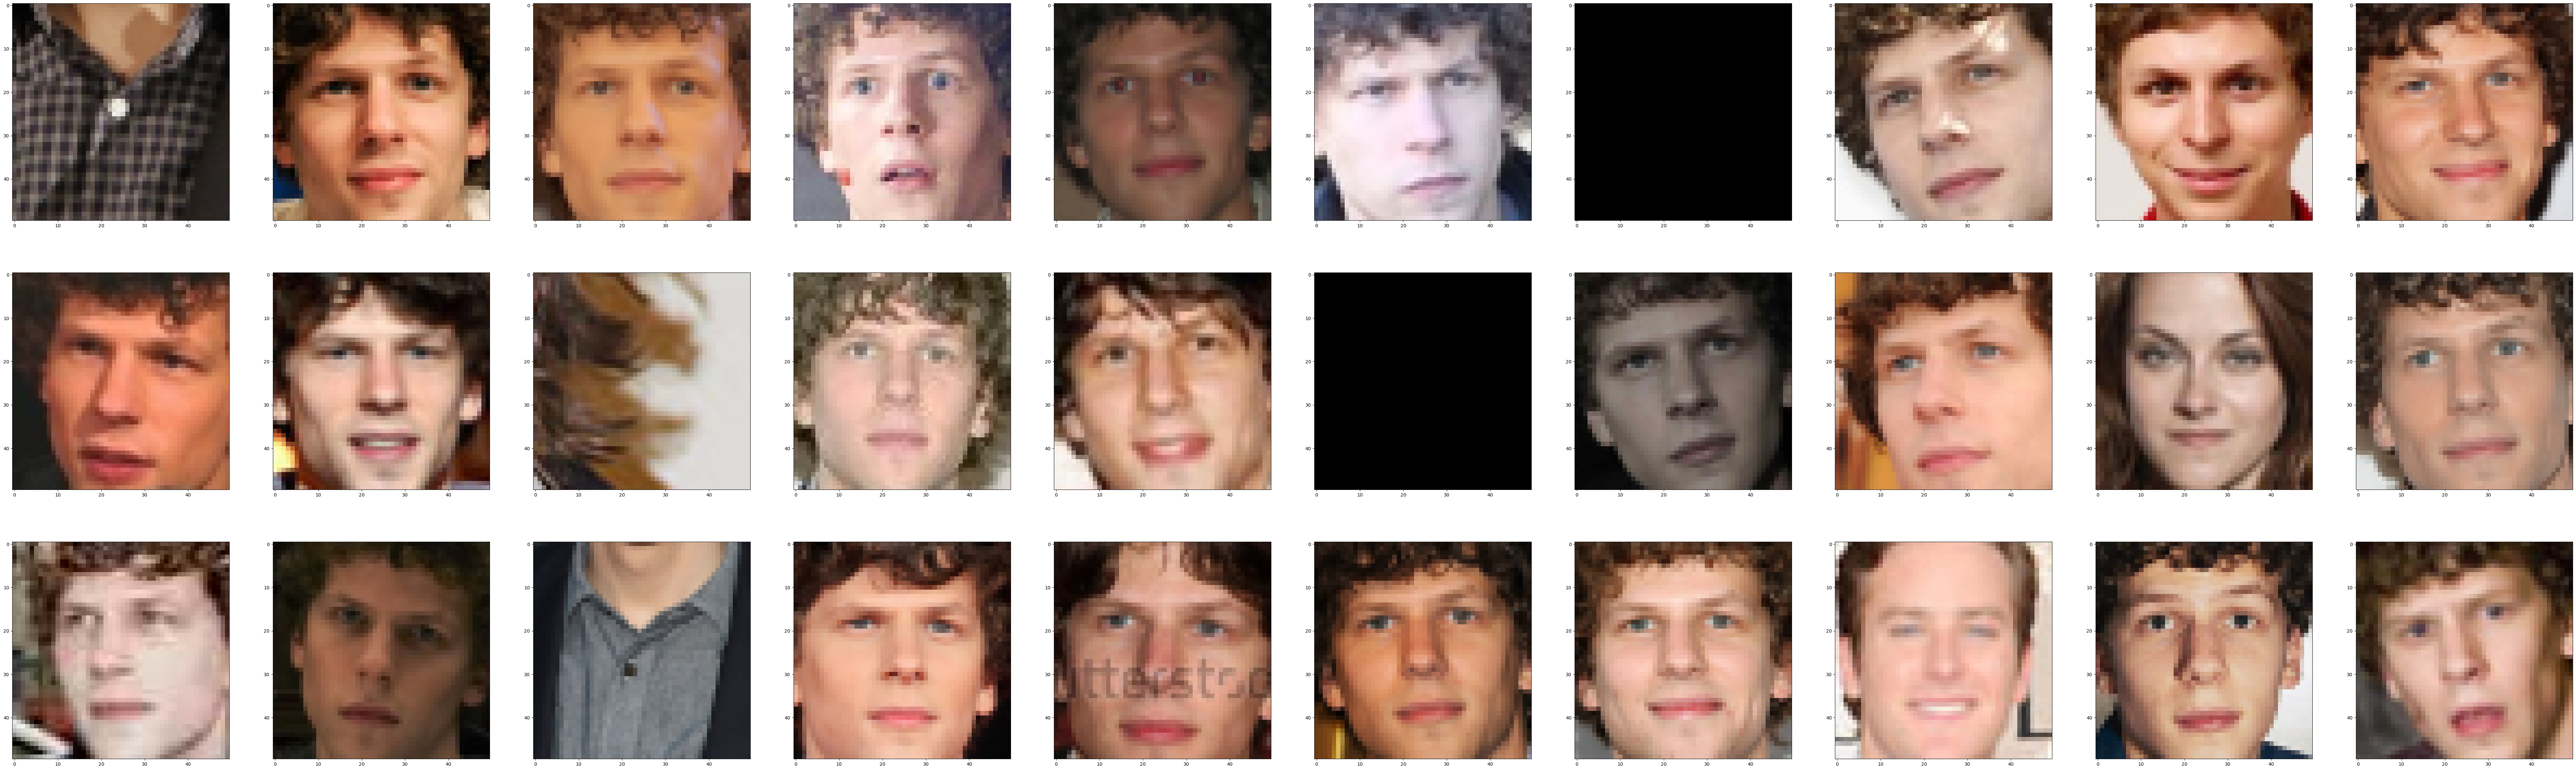

In [9]:
# plot faces of Jesse

plot_image_sequence(train_X[train_y == 1], n=30, imgs_per_row=10)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


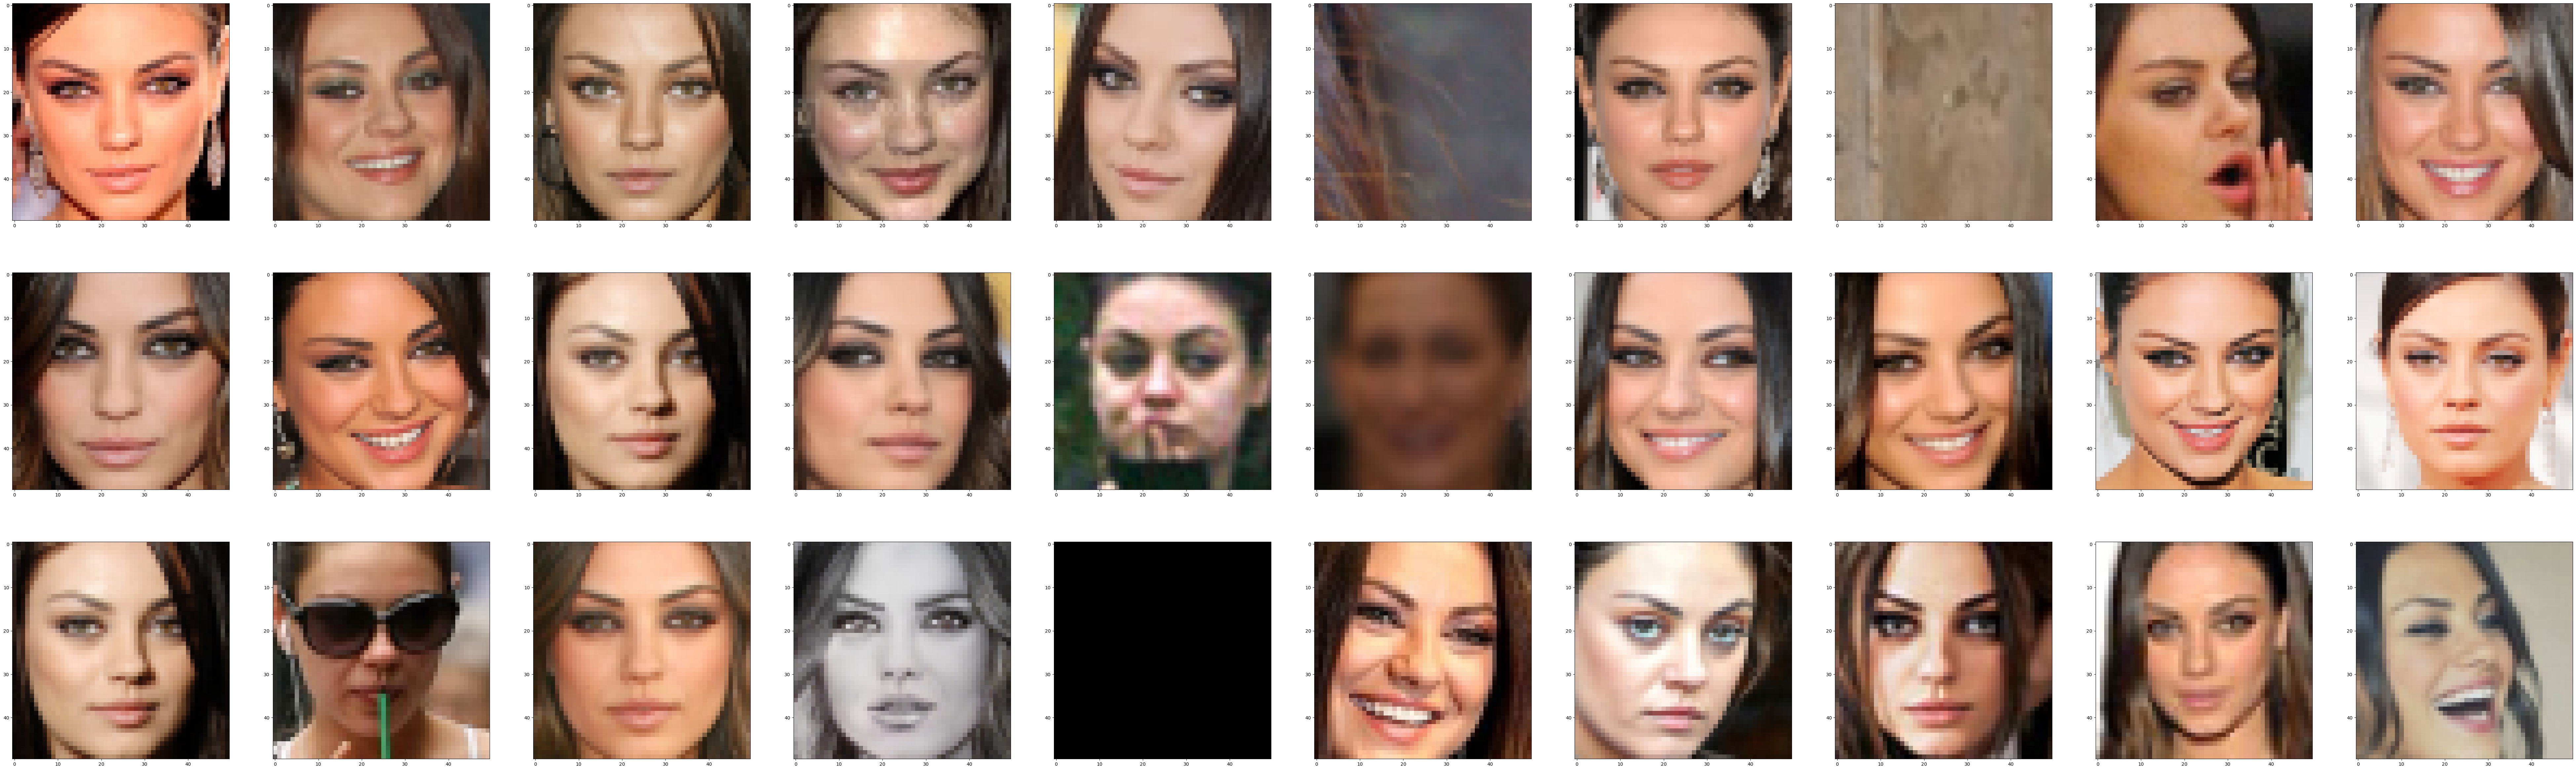

In [10]:
# plot faces of Mila

plot_image_sequence(train_X[train_y == 2], n=30, imgs_per_row=10)

Discard false positive faces from the training data

In [11]:
train_X.shape

(80, 50, 50, 3)

In [12]:
# Save the indices of the 
indices_to_delete = [] 

# Go over the training data, and delete images with negative pixel values
for i, img in enumerate(train_X):
    # Check if this image has any negative pixel value
    if np.any(img.flatten() < 0):
        print(f"Deleting image {i} from training data")
        indices_to_delete.append(i)
        

# Save copy with (possibly) deleted false positives again data 
train_X = np.delete(train_X, indices_to_delete, axis=0)

Deleting image 14 from training data
Deleting image 35 from training data
Deleting image 65 from training data


In [13]:
train_X.shape

(77, 50, 50, 3)

In [14]:
# NOTE - testing the above result here -- are there still false positives saved?
# Go over the training data, and delete images with negative pixel values
for i, img in enumerate(train_X):
    # Check if this image has any negative pixel value
    if np.any(img.flatten() < 0):
        print(f"WATCH OUT Image {i} does not have face -- there is a bug in the above code")

## 0.4. Store Preprocessed data (optional)
<div class="alert alert-block alert-info">
<b>NOTE:</b> You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All". Feel free to use this to store intermediary results.
</div>

In [15]:
# save preprocessed data
# prep_path = '/kaggle/working/prepped_data/'
# if not os.path.exists(prep_path):
#     os.mkdir(prep_path)
    
# np.save(os.path.join(prep_path, 'train_X.npy'), train_X)
# np.save(os.path.join(prep_path, 'train_y.npy'), train_y)
# np.save(os.path.join(prep_path, 'test_X.npy'), test_X)

# load preprocessed data
# prep_path = '/kaggle/working/prepped_data/'
# if not os.path.exists(prep_path):
#     os.mkdir(prep_path)
# train_X = np.load(os.path.join(prep_path, 'train_X.npy'))
# train_y = np.load(os.path.join(prep_path, 'train_y.npy'))
# test_X = np.load(os.path.join(prep_path, 'test_X.npy'))

Now we are ready to rock!

# 1. Feature Representations
## 1.0. Example: Identify feature extractor
Our example feature extractor doesn't actually do anything... It just returns the input:
$$
\forall x : f(x) = x.
$$

It does make for a good placeholder and baseclass ;).

In [16]:
class IdentityFeatureExtractor:
    """A simple function that returns the input"""
    
    def transform(self, X):
        return X
    
    def __call__(self, X):
        return self.transform(X)

## 1.1. Baseline 1: HOG feature extractor/Scale Invariant Feature Transform
...

In [17]:
class HOGFeatureExtractor(IdentityFeatureExtractor):
    """TODO: this feature extractor is under construction"""
    
    def __init__(**params):
        self.params = params
        
    def transform(self, X):
        raise NotImplmentedError

### 1.1.1. t-SNE Plots
...

### 1.1.2. Discussion
...

## 1.2. Baseline 2: PCA feature extractor

See *Artificial Neural Networks course, Assignment 3* for mathematical details. 

In [129]:
class PCAFeatureExtractor(IdentityFeatureExtractor):
    """
    PCA feature extractor which, given training data, finds the ideal set of principal components. Inspired by assignment 3 of the artificial neural networks course.
    """

    def __init__(self, n_components, use_cov_matrix=False):
        """
        Initialize the PCA feature extractor.
        :param: n_components: This is either an integer, denoting the number of principal components we keep, or a float between 0 and 1, 
        indicating the amount of variance that should be explained through the PCA. 
        """

        self.n_components_ = n_components
        # ^ the number of principal components to be computed
        self.use_cov_matrix = use_cov_matrix
        # ^ use covariance matrix to compute eigenvectors and eigenvalues, or exploit the mathematical trick
        self.meanface_         = None
        # ^ the mean of all the input training data
        self.projection_matrix = None 
        # ^ the projection matrix, called E in asssignment 3 of the ANN course. Multiply with input data to find the reduced vector 

        # We will save the original shape of the input data for convenience, used inside this class
        self.original_width     = None
        self.original_height    = None
        self.n_samples          = None

        # We will save the eigenvalues and eigenvectors, such that we can change the number of principal components and easily refit the PCA 
        self.eigenvals    = None
        self.eigenvectors = None


    def fit(self, X):
        """
        Fit the PCA to the training data. Calls other functions
        :param: X: Numpy array of size (n_samples, width, height, 3). Note: input must be color images!
        """
        self.compute_meanface(X)
        self.compute_eigensystem(X)
        self.compute_projection_matrix()

    def compute_meanface(self, X):
        # Save the original shape for later on
        self.n_samples, self.original_width, self.original_height = X.shape[0], X.shape[1], X.shape[2]
        # Convert images to grayscale
        X_gray = np.mean(X, axis=3)
        # Flatten images
        X_gray_flattened = np.reshape(X_gray, (X_gray.shape[0], (X_gray.shape[1]*X_gray.shape[2])))
        # We got one dimension less because we collapsed it into a vector. We calculate the mean of all columns
        self.meanface_ = np.mean(X_gray_flattened, axis=0)

        return self.meanface_
        
    def compute_eigensystem(self, X):
        """
        Compute the eigenvalues and eigenvectors of the covariance matrix of the training data X. 
        :param: X: Numpy array of size (n_samples, width, height, 3). Note: input must be color images!
        """
        # Convert to grayscale
        X_gray = np.mean(X, axis=3)

        # preserve original face => self contained. No need to use global variables.
        # self.original_shape = X_gray.shape
        # n_samples, width, height = self.original_shape

        # Flatten the images
        X_gray_flattened = np.reshape(X_gray, (X_gray.shape[0], (X_gray.shape[1]*X_gray.shape[2])))

        # Compute meanface (if not done yet)
        if self.meanface_ is None:
            self.compute_meanface(X)

        # Subtract mean image from all images (center the data)
        subtracted_mean_faces = X_gray_flattened - self.meanface_

        # Get the covariance matrix
        # rowvar is set to False: the rows are the examples, columns are the variables (the pixels of the faces)
        # TODO - we put this back to True, and not False, as we try to implement the mathematical trick
        # >> https://sandipanweb.wordpress.com/2018/01/06/eigenfaces-and-a-simple-face-detector-with-pca-svd-in-python/

        self.data_matrix = subtracted_mean_faces
        covariance_matrix = np.cov(self.data_matrix, rowvar=False)
        self.covariance_matrix = covariance_matrix  # save as class variable

        # Compute the eigenvalues and eigenvectors
        
        # First, compute the eigenvals and eigenvecs of the "transposed" covariance matrix, see mathematical trick
        # >> https://sandipanweb.wordpress.com/2018/01/06/eigenfaces-and-a-simple-face-detector-with-pca-svd-in-python/

        # Check which matrix we are going to use for the decomposition
        if not self.use_cov_matrix:
            matrix = np.cov(self.data_matrix, rowvar=True)
        else:
            matrix = self.covariance_matrix

        # Compute the eigensystem
        eigenvals, other_eigenvectors = np.linalg.eig(matrix)

        # If not using the covariance matrix but we use the mathematical trick, have to convert the vectors
        eigenvectors = []

        # Sort highest to lowest, and keep the sorting indices
        highest_indexes = np.flip(eigenvals.argsort())
        # Sort the eigenvals and eigenvectors accordingly
        eigenvals = eigenvals[highest_indexes]
        other_eigenvectors = other_eigenvectors[:, highest_indexes]

        if self.use_cov_matrix:
            # TODO - why transpose?
            eigenvectors = np.transpose(other_eigenvectors)
        else:
            # If necessary, convert the eigenvectors to ones for our size
            eigenvectors = np.array([np.matmul(np.transpose(self.data_matrix), vec) for vec in other_eigenvectors])
        
        # Save the eigenvals and vectors to reuse them again later on, but cast from complex to real type and normalize vectors
        self.eigenvals = np.real(eigenvals)
        self.eigenvectors = np.real(np.array([vec/np.linalg.norm(vec) for vec in eigenvectors]))

        return self.eigenvals, self.eigenvectors

    
    def compute_projection_matrix(self):
        """
        Computes the projection matrix which is used in (inverse) transform. See Assignment 3 of artificial neural networks for details.
        Here we use the number of components, so if we want to change the number of components, you shouldn't call fit, but you can reuse
        earlier calculations and just call this to update the projection matrix. 
        """

        # Check if eigenvalues and eigenvectors were computed before
        if self.eigenvals is None or self.eigenvectors is None: 
            raise ValueError("PCA eigensystem not set")
        
        # If n_components is a float between 0 and 1, compute the number of components (int) through cumulative sum eigenvals
        if not isinstance(self.n_components_, int):
            # Get fractions: cumulative sum up to index divided by the total sum
            fractions = np.cumsum(self.eigenvals)/np.sum(self.eigenvals)
            # Check where the cumulative sum is still between the threshold: then 1, else 0. Sum to convert to number of components to keep 
            self.n_components_ = np.sum(np.where(fractions < self.n_components_, 1, 0))

        # Make sure that the number of components is not too large:
        self.n_components_ = min(self.n_samples, self.n_components_)
        
        # Select the eigenvectors to keep
        selected_eigenvectors = self.eigenvectors[:self.n_components_, :]
        # # Make sure they are real
        # selected_eigenvectors = selected_eigenvectors

        # Save the projection matrix (called E in artificial neural networks assignment 3)
        self.projection_matrix = selected_eigenvectors

        return self.projection_matrix


    def transform(self, X_gray):
        """
        Transform given images with the projection matrix obtained from the principal components.
        :param: X_gray: Numpy array, stack of 2D grayscale images OR a single 2D grayscale image. 
        """

        # Check if the projection matrix was already calculated
        if self.projection_matrix is None:
            raise ValueError("Projection matrix is None.")

        # Check if we have a single 2D image, then we have to do a simple matrix multiplication
        if len(X_gray.shape) == 2:
            # Return simple matrix multiplication, flatten the array
            return np.matmul(self.projection_matrix, X_gray.flatten())

        # If we have several images, the code is a bit more involved...
        
        # Extract the shape of these images
        n_samples, width, height = X_gray

        # Check if these images have same shape as training data
        if not (width == self.original_width) and (height == self.original_height):
            raise ValueError("Input images for transform do not have correct shape")

        # Flatten the images
        X_gray_flattened = np.reshape(X_gray, (n_samples, (self.original_width*self.original_height)))

        # Initialize empty array of correct size
        reduced = np.empty((n_samples, self.n_components_))
        # Iterate over all images, transform them with matrix multiplication (see assignment 3 artificial neural networks course)
        for i, img in enumerate(X_gray_flattened):
            reduced[i, :] = np.matmul(self.projection_matrix, img)
        
        return reduced
        

    def inverse_transform(self, X):
        """
        Computes the inverse transformation. Here, X is a numpy array of flattened vectors, each of size n_components_
        :param: X: Numpy array of size (n_samples, n_components_). Note: input must be flat vectors!
        """

        # Check if we have a single image to convert: only requires a simple matrix multiplication
        if len(X.shape) == 1:
            return np.matmul(np.transpose(self.projection_matrix), X)

        # If we have several images, the code is a bit more involved...

        # Get the amount of samples to be transformed
        n_samples = X.shape[0]
        
        # Reconstructed: n_samples images, hence has shape (n_samples, (width, height)), using the original width and height
        reconstructed = np.empty((n_samples, (self.original_width, self.original_height)))

        # Iterate over all images, transform them with matrix multiplication (see assignment 3 artificial neural networks course)
        for i, img in enumerate(X):
            # Multiply with E, the projection matrix, and reshape as square matrix (2D image) again
            reconstructed[i, :, :] = np.matmul(np.transpose(self.projection_matrix), img).reshape((self.original_width, self.original_height))
        
        return reconstructed 
        
        

Initialize a new PCA object. __Note:__ if number of components is a float between 0 and 1 (such as below: 0.95), PCAFeatureExtractor will figure out the right number of components such that 95% of explained variance is kept in the components kept by PCA.

In [130]:
ncp = 0.9999
pca = PCAFeatureExtractor(ncp, use_cov_matrix=False)

(if not done already:) Compute and save the eigenvalues and eigenvectors of the training data. __Saving what?__ See discussion below!!!

In [131]:
# Fit the PCA
pca.fit(train_X)

# Save with Pickle
with open('eigenvals.pickle', 'wb') as handle:
    pickle.dump(pca.eigenvals, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('eigenvectors.pickle', 'wb') as handle:
    pickle.dump(pca.eigenvectors, handle, protocol=pickle.HIGHEST_PROTOCOL)

The shape of the projection matrix is: (original_dimensionality, reduced_dimensionality), where "original" refers to the flattened images.

In [132]:
np.shape(pca.projection_matrix)

(75, 77)

__IMPORTANT DISCUSSION:__ 
In case we have a large value for `FACE_SIZE`, we can compute the eigenvalues and eigenvectors once and save them with Pickle (this is done by default above, see the cell where we fit the PCA). Afterwards, we can load the saved eigenvals and eigenvectors and save it into our PCA object, after which we still have to compute the other variables, such as meanface. This is done in the cell below. From my observations, it seems that `FACE_SIZE` of (50, 50) seems OK and takes only around 16 seconds. Be careful that a `FACE_SIZE` of (100, 100) took my laptop around 10 minutes to compute. 

In [133]:
# with open('eigenvals.pickle', 'rb') as handle:
#     eigenvals = pickle.load(handle)

# with open('eigenvectors.pickle', 'rb') as handle:
#     eigenvectors = pickle.load(handle)

# # Load them into our PCA object
# pca.eigenvals = eigenvals
# pca.eigenvectors = eigenvectors

## If we are loading old eigenvalues and eigenvectors, manually set the other parameters of PCA
# pca.compute_meanface(train_X)
# train_X_gray = np.mean(train_X, axis=3)
# pca.set_shape(train_X_gray)
# pca.compute_projection_matrix()

### 1.2.1. Eigenface Plots

In [134]:
# We use a scikit function to rescale pixel values to the (0, 255) range
from skimage.exposure import rescale_intensity

Plot the mean face

In [135]:
pca.eigenvectors

array([[ 0.06353974,  0.10790907,  0.16604123, ...,  0.09513612,
         0.17237573, -0.16313775],
       [ 0.00892564,  0.14997288,  0.10234486, ...,  0.1032538 ,
         0.1995853 , -0.08480497],
       [ 0.01091222,  0.12551365,  0.05765299, ...,  0.01711717,
         0.21182405, -0.07233959],
       ...,
       [-0.08934246, -0.02774035, -0.06769539, ..., -0.04420021,
         0.05257512, -0.08583946],
       [-0.091767  ,  0.02284606, -0.0335966 , ...,  0.00067983,
         0.04210813, -0.13387965],
       [-0.05379621, -0.02787722, -0.02045536, ...,  0.00905351,
         0.09937343, -0.1485222 ]])

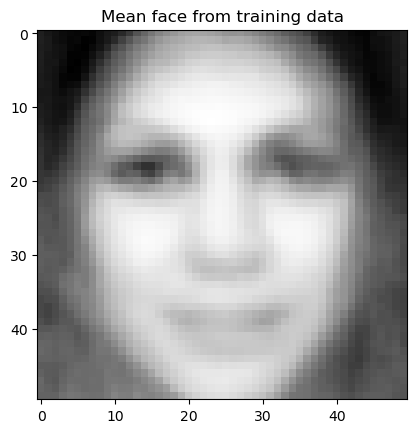

In [136]:
plt.imshow(pca.meanface_.reshape(FACE_SIZE), cmap="Greys_r")
plt.title("Mean face from training data")
plt.show()

Plot examples of the eigenfaces (not all shown here)

In [137]:
# Eigenfaces are eigenvectors, which are saved in the projection matrix: reshape, rescale pixel values & create 3 channels
eigenfaces = pca.projection_matrix
eigenfaces = np.array([rescale_intensity(face, out_range=(0, 255)).astype(np.uint8) for face in eigenfaces])
eigenfaces = np.array([face.reshape(FACE_SIZE) for face in eigenfaces])
eigenfaces = np.array([cv2.merge((face, face, face)) for face in eigenfaces])

# Choose how many eigenfaces to plot (please, a multiple of two)
nb_eigenfaces_to_show = 20
plot_image_sequence(eigenfaces[0:nb_eigenfaces_to_show], n=nb_eigenfaces_to_show, imgs_per_row=nb_eigenfaces_to_show//2)

ValueError: cannot reshape array of size 77 into shape (50,50)

### 1.2.2. Feature Space Plots

__NOTE:__ I don't know what should be plotted here?

I'm going to plot just an example of a "reconstructed" face (transformed, then inverse transformed)... Is this the purpose of this section?

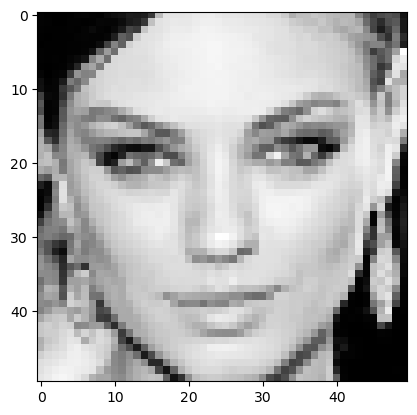

In [127]:
# test the functions on the very first training image, just an illustration!
test_face = train_X[0]
# Convert to grayscale
test_face_gray = cv2.cvtColor(test_face.astype('uint8'), cv2.COLOR_BGR2GRAY)
# Show image
plt.imshow(test_face_gray, cmap="Greys_r")
plt.show()

Do transformation & inverse transformation:

Shape after transformation: (75,)
Shape after reconstruction: (2500,)


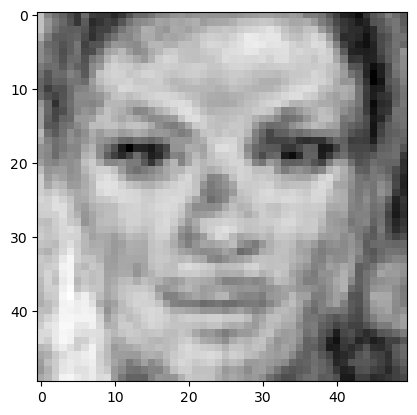

In [128]:
reduced = pca.transform(test_face_gray)
print(f"Shape after transformation: {reduced.shape}")
reconstructed = pca.inverse_transform(reduced)
print(f"Shape after reconstruction: {reconstructed.shape}")
# Show reconstructed face:
plt.imshow(reconstructed.reshape(FACE_SIZE), cmap="Greys_r")
plt.show()

### 1.2.3. Discussion

# 2. Evaluation Metrics
## 2.0. Example: Accuracy
As example metric we take the accuracy. Informally, accuracy is the proportion of correct predictions over the total amount of predictions. It is used a lot in classification but it certainly has its disadvantages...

In [ ]:
from sklearn.metrics import accuracy_score

# 3. Classifiers
## 3.0. Example: The *'not so smart'* classifier
This random classifier is not very complicated. It makes predictions at random, based on the distribution obseved in the training set. **It thus assumes** that the class labels of the test set will be distributed similarly to the training set.

In [ ]:
class RandomClassificationModel:
    """Random classifier, draws a random sample based on class distribution observed 
    during training."""
    
    def fit(self, X, y):
        """Adjusts the class ratio instance variable to the one observed in y. 

        Parameters
        ----------
        X : tensor
            Training set
        y : array
            Training set labels

        Returns
        -------
        self : RandomClassificationModel
        """
        
        self.classes, self.class_ratio = np.unique(y, return_counts=True)
        self.class_ratio = self.class_ratio / self.class_ratio.sum()
        return self
        
    def predict(self, X):
        """Samples labels for the input data. 

        Parameters
        ----------
        X : tensor
            dataset
            
        Returns
        -------
        y_star : array
            'Predicted' labels
        """

        np.random.seed(0)
        return np.random.choice(self.classes, size = X.shape[0], p=self.class_ratio)
    
    def __call__(self, X):
        return self.predict(X)
    

## 3.1. Baseline 1: My favorite classifier
...

In [ ]:
class FavoriteClassificationModel:
    """TODO: this classifier is under construction."""
    
    def fit(self, X, y):
        raise NotImplmentedError
        
    def predict(self, X):
        raise NotImplmentedError

# 4. Experiments
<div class="alert alert-block alert-info"> <b>NOTE:</b> Do <i>NOT</i> use this section to keep track of every little change you make in your code! Instead, highlight the most important findings and the major (best) pipelines that you've discovered.  
</div>
<br>

## 4.0. Example: basic pipeline
The basic pipeline takes any input and samples a label based on the class label distribution of the training set. As expected the performance is very poor, predicting approximately 1/4 correctly on the training set. There is a lot of room for improvement but this is left to you ;). 

In [ ]:
feature_extractor = IdentityFeatureExtractor() 
classifier = RandomClassificationModel()

# train the model on the features
classifier.fit(feature_extractor(train_X), train_y)

# model/final pipeline
model = lambda X: classifier(feature_extractor(X))

In [ ]:
# evaluate performance of the model on the training set
train_y_star = model(train_X)

"The performance on the training set is {:.2f}. This however, does not tell us much about the actual performance (generalisability).".format(
    accuracy_score(train_y, train_y_star))

In [ ]:
# predict the labels for the test set 
test_y_star = model(test_X)

# 5. Publishing best results

In [ ]:
submission = test.copy().drop('img', axis = 1)
submission['class'] = test_y_star

submission

In [ ]:
submission.to_csv('submission.csv')

# 6. Discussion
...

In summary we contributed the following: 
* 
